<a href="https://colab.research.google.com/github/iSarahSajjad/neuro-chronical-prediction/blob/Models/3d_CNN15_model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
import pickle
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import json
import os
from tensorflow.keras import layers, models

# Directory containing the balanced batches
balanced_batch_dir = '/content/drive/My Drive/ChronicAI/dataset/balanced_batches'

def load_data_from_batches(batch_dir):
    batch_files = [f for f in os.listdir(batch_dir) if f.endswith('.pkl')]
    all_data = []
    all_labels = []

    for batch_file in batch_files:
        batch_path = os.path.join(batch_dir, batch_file)
        with open(batch_path, 'rb') as f:
            batch_data, batch_labels = pickle.load(f)
            all_data.append(batch_data)
            all_labels.append(batch_labels)

    # Concatenate all batches
    all_data = np.concatenate(all_data, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    return all_data, all_labels

X, y = load_data_from_batches(balanced_batch_dir)

# Split data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1/(1-0.2), random_state=42)

# Model Input Shape
input_shape = (128, 128, 128, 1)  # Assuming grayscale images, adjust if needed
num_classes = 3  # Number of classes

def dense_block(x, num_layers, growth_rate):
    for _ in range(num_layers):
        cb = layers.BatchNormalization()(x)
        cb = layers.ReLU()(cb)
        cb = layers.Conv3D(growth_rate, (3, 3, 3), padding='same')(cb)
        x = layers.Concatenate()([x, cb])
    return x

def transition_layer(x, reduction):
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv3D(int(x.shape[-1] * reduction), (1, 1, 1), padding='same')(x)
    x = layers.MaxPooling3D((2, 2, 2), strides=(2, 2, 2))(x)
    return x

def dense_unet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv3D(64, (3, 3, 3), padding='same')(inputs)
    x = dense_block(x, 4, 32)
    x = transition_layer(x, 0.5)

    x = dense_block(x, 4, 32)
    x = transition_layer(x, 0.5)

    x = dense_block(x, 4, 32)
    x = transition_layer(x, 0.5)

    # Bottleneck
    x = dense_block(x, 4, 32)

    # Decoder
    x = layers.Conv3DTranspose(128, (3, 3, 3), strides=(2, 2, 2), padding='same')(x)
    x = dense_block(x, 4, 32)

    x = layers.Conv3DTranspose(64, (3, 3, 3), strides=(2, 2, 2), padding='same')(x)
    x = dense_block(x, 4, 32)

    x = layers.Conv3DTranspose(32, (3, 3, 3), strides=(2, 2, 2), padding='same')(x)
    x = dense_block(x, 4, 32)

    outputs = layers.Conv3D(num_classes, (1, 1, 1), activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Create the model
model = dense_unet(input_shape, num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Callbacks
checkpoint_path = '/content/drive/My Drive/ChronicAI/models/3d_dense_unet_epoch_1_{epoch:02d}.keras'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=4,
    callbacks=[early_stopping, checkpoint_callback]
)

# Save model and training history
model.save('/content/drive/My Drive/ChronicAI/models/3d_dense_unet_model_1.keras')

with open('/content/drive/My Drive/ChronicAI/models/training_history_3d_dense_unet.json', 'w') as f:
    json.dump(history.history, f)

# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=-1)

# Flatten arrays for metrics
y_test_flat = y_test.flatten()
y_pred_flat = y_pred_classes.flatten()

# Calculate metrics
f1 = f1_score(y_test_flat, y_pred_flat, average='weighted')
print(f'F1 Score: {f1}')

# Confusion Matrix
cm = confusion_matrix(y_test_flat, y_pred_flat)
print('Confusion Matrix:')
print(cm)

# Extracting TP, FP, TN, FN from the confusion matrix
# This assumes binary classification with 2 classes
tn, fp, fn, tp = cm.ravel()
print(f'True Positive: {tp}')
print(f'False Positive: {fp}')
print(f'True Negative: {tn}')
print(f'False Negative: {fn}')

# Plot training history
with open('/content/drive/My Drive/ChronicAI/models/training_history_3d_dense_unet.json', 'r') as f:
    history = json.load(f)

plt.figure(figsize=(12, 6))
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [7]:
import pandas as pd
import os

main_file_path = '/content/drive/My Drive/ChronicAI/dataset/participants.tsv'

# Read the TSV file into a DataFrame using pandas
main_df = pd.read_csv(main_file_path, sep='\t')

base_dir = '/content/drive/My Drive/ChronicAI/dataset/'

# Create a list to store the combined data
combined_data = []

# Keep only the specified columns
main_df = main_df[['participant_id', 'age', 'origin', 'group']]

# Iterate through each row in the main DataFrame
for index, row in main_df.iterrows():
    participant_id = row['participant_id']

    # Define the path to the participant's directory
    participant_dir = os.path.join(base_dir, str(participant_id))

    # Check if the directory exists
    if os.path.exists(participant_dir):
        # Get a list of all TSV files in the participant's directory
        tsv_files = [f for f in os.listdir(participant_dir) if f.endswith('.tsv')]

        # Iterate through each TSV file
        for tsv_file in tsv_files:
            tsv_file_path = os.path.join(participant_dir, tsv_file)

            # Read the TSV file into a DataFrame
            participant_df = pd.read_csv(tsv_file_path, sep='\t')

            # Add the participant's ID to the DataFrame
            participant_df['participant_id'] = participant_id

            # Append the DataFrame to the combined data list
            combined_data.append(participant_df)

# Combine all the DataFrames in the list into a single DataFrame
combined_df = pd.concat(combined_data, ignore_index=True)

# Merge the combined DataFrame with the main DataFrame on participant_id
final_df = pd.merge(main_df, combined_df, on='participant_id', how='left')

# Display the first few rows of the final DataFrame
print(final_df.head())

  participant_id  age origin     group session_id  days_since_interview  \
0        sub-001   27      4  subacute  interview                   0.0   
1        sub-001   27      4  subacute     visit1                   4.0   
2        sub-001   27      4  subacute     visit2                  94.0   
3        sub-001   27      4  subacute     visit3                   NaN   
4        sub-001   27      4  subacute     visit4                 395.0   

  hours_sleep smoker limited_self_care/mobility bdi_total  ...  pdi_total  \
0      6 to 7      n                          y       1.0  ...          2   
1      6 to 7      n                          n       NaN  ...         17   
2         NaN    NaN                        NaN       NaN  ...         21   
3           7      n                          n       7.0  ...          2   
4         NaN    NaN                        NaN       7.0  ...          2   

   pdetect_pain_now  pdetect_strongest_4wks pdetect_pain_average_4wks  \
0            

In [13]:
import nibabel as nib
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from scipy.ndimage import zoom
import os

# Filter data by group
groups = ['healthy', 'chronic', 'subacute']
filtered_dfs = {group: final_df[final_df['group'] == group] for group in groups}

# Initialize lists to store data and labels
all_data = []
all_labels = []

# Function to load, normalize, and resize MRI data
def load_and_process_mri(file_path, target_size=(64, 64, 64)):
    try:
        img = nib.load(file_path)
        img_data = img.get_fdata()
        img_data = (img_data - np.min(img_data)) / (np.max(img_data) - np.min(img_data))

        # Resize to target size if necessary
        if img_data.shape != target_size:
            factors = [t / s for s, t in zip(img_data.shape, target_size)]
            img_data = zoom(img_data, factors, order=1)  # Use zoom from scipy

        return img_data
    except Exception as e:
        print(f"Error loading or processing {file_path}: {e}")
        return None

# Process each group
for group in groups:
    df = filtered_dfs[group]
    print(f"Processing group: {group}, Number of participants: {len(df)}")

    for _, row in df.iterrows():
        participant_id = row['participant_id']
        session_id = row['session_id']
        session_folder = f"ses-{session_id}"
        anat_path = os.path.join(base_dir, str(participant_id), session_folder, 'anat')

        if os.path.exists(anat_path):
            for file_name in os.listdir(anat_path):
                if file_name.endswith('.nii'):
                    file_path = os.path.join(anat_path, file_name)
                    #img_data = load_and_process_mri(file_path)
                    img_data = file_path
                    if img_data is not None:
                        # Add channel dimension
                        img_data = np.expand_dims(img_data, axis=-1)
                        all_data.append(img_data)
                        all_labels.append(group)
                    break  # Only one sample per session

# Convert data and labels to numpy arrays
all_data = np.array(all_data)
all_labels = np.array(all_labels)

# Encode labels as integers and then one-hot vectors
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(all_labels)
one_hot_labels = to_categorical(integer_labels, num_classes=len(groups))
# Verify shape of all_data
print("Shape of all_data:", all_data.shape)
# Ensure the correct input shape for Conv3D
input_shape = all_data.shape[1:]  # Exclude the number of samples
input_shape = (1, 128, 128, 3)
all_data_reshaped = all_data.reshape(-1, *input_shape)
# Create a 3D CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling3D((2, 2, 2)),
    tf.keras.layers.Conv3D(64, (3, 3, 3), activation='relu'),
    tf.keras.layers.MaxPooling3D((2, 2, 2)),
    tf.keras.layers.Conv3D(128, (3, 3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(groups), activation='softmax')  # Ensure len(groups) matches the number of classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
#model.fit(all_data, one_hot_labels, epochs=10, batch_size=32, validation_split=0.2)
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(all_data, one_hot_labels, test_size=0.2, random_state=42)
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val))


Processing group: healthy, Number of participants: 130
Processing group: chronic, Number of participants: 130
Processing group: subacute, Number of participants: 390
Shape of all_data: (434, 1)


ValueError: cannot reshape array of size 434 into shape (1,128,128,3)

In [ ]:
# Save model and training history
model.save('/content/drive/My Drive/ChronicAI/models/3d_CNN_15Epochs.keras')

with open('/content/drive/My Drive/ChronicAI/models/training_history_3d_CNN_15Epochs.json', 'w') as f:
    json.dump(history.history, f)

# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=-1)

# Flatten arrays for metrics
y_test_flat = y_test.flatten()
y_pred_flat = y_pred_classes.flatten()

# Calculate metrics
f1 = f1_score(y_test_flat, y_pred_flat, average='weighted')
print(f'F1 Score: {f1}')

# Confusion Matrix
cm = confusion_matrix(y_test_flat, y_pred_flat)
print('Confusion Matrix:')
print(cm)

# Extracting TP, FP, TN, FN from the confusion matrix
# This assumes binary classification with 2 classes
tn, fp, fn, tp = cm.ravel()
print(f'True Positive: {tp}')
print(f'False Positive: {fp}')
print(f'True Negative: {tn}')
print(f'False Negative: {fn}')

# Plot training history
with open('/content/drive/My Drive/ChronicAI/models/training_history_3d_CNN_15Epochs.json', 'r') as f:
    history = json.load(f)

plt.figure(figsize=(12, 6))
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")
import matplotlib.pyplot as plt

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


Processing group: healthy, Number of participants: 130
Processing group: chronic, Number of participants: 130
Processing group: subacute, Number of participants: 390


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6294 - loss: 1.2285
Epoch 1: val_loss improved from inf to 0.59881, saving model to 3d_cnn_model_best.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.6292 - loss: 1.2261 - val_accuracy: 0.8182 - val_loss: 0.5988
Epoch 2/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5618 - loss: 0.9934
Epoch 2: val_loss did not improve from 0.59881
76/76 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.5623 - loss: 0.9929 - val_accuracy: 0.8182 - val_loss: 0.7059
Epoch 3/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6109 - loss: 0.9489
Epoch 3: val_loss improved from 0.59881 to 0.59820, saving model to 3d_cnn_model_best.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.6108 - loss: 0.9490 - val_accuracy: 0.8182 - val_loss: 0.5982
Epoch 4/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6133 - loss: 0.9328
Epoch 4: val_loss did not improve from 0.59820
76/76 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accu

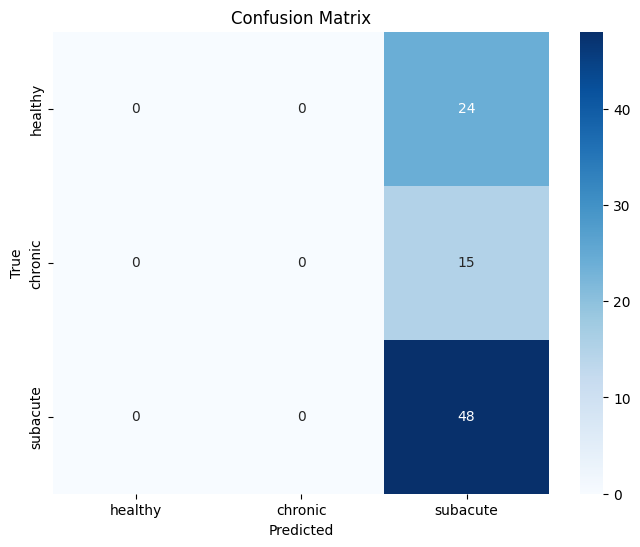

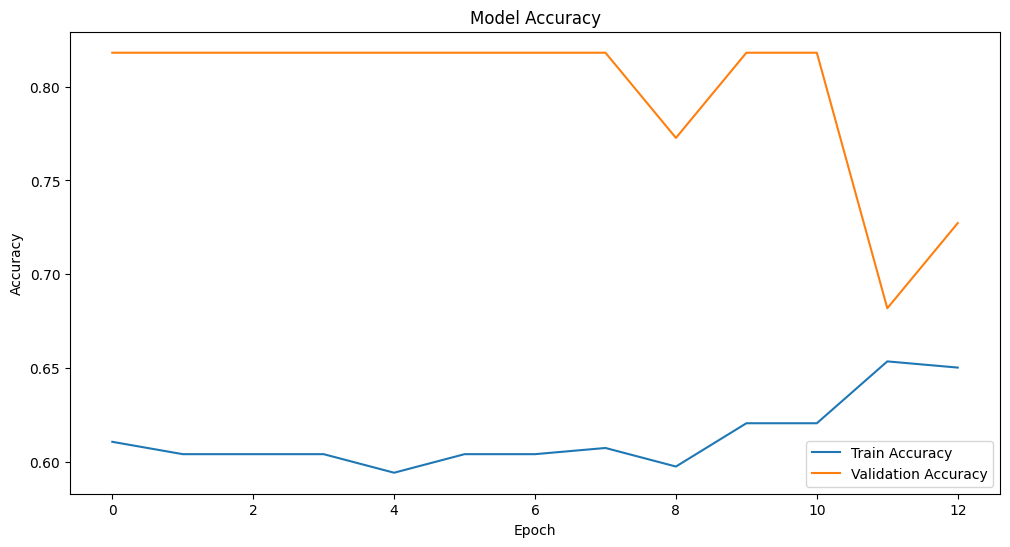

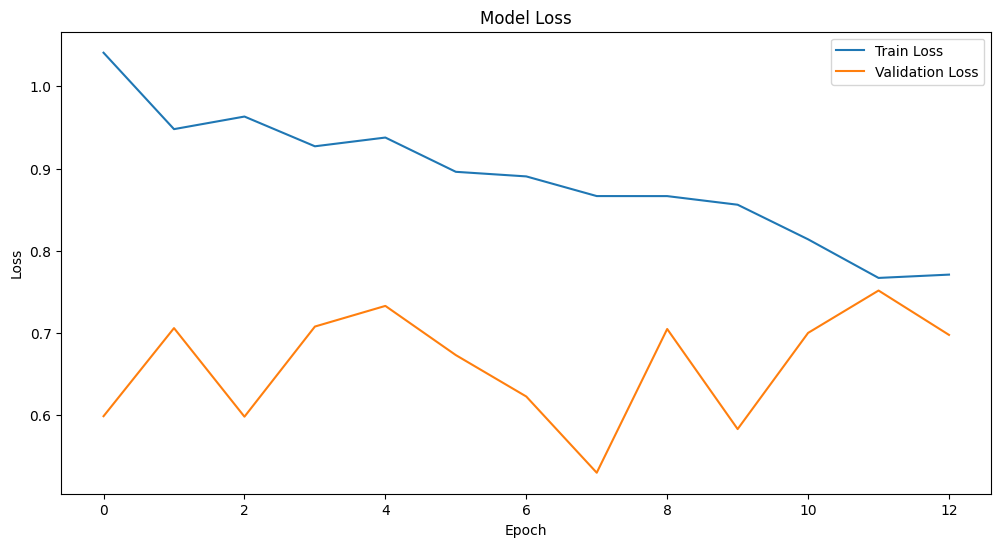

In [14]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense
import matplotlib.pyplot as plt
import seaborn as sns


# Filter data by group
groups = ['healthy', 'chronic', 'subacute']
filtered_dfs = {group: final_df[final_df['group'] == group] for group in groups}

# Initialize lists to store data and labels
all_data = []
all_labels = []

# Function to load, normalize, and resize MRI data
def load_and_process_mri(file_path, target_size=(64, 64, 64)):
    try:
        img = nib.load(file_path)
        img_data = img.get_fdata()
        img_data = (img_data - np.min(img_data)) / (np.max(img_data) - np.min(img_data))

        # Resize to target size if necessary
        if img_data.shape != target_size:
            factors = [t / s for s, t in zip(img_data.shape, target_size)]
            img_data = zoom(img_data, factors, order=1)  # Use zoom from scipy

        return img_data
    except Exception as e:
        print(f"Error loading or processing {file_path}: {e}")
        return None

# Process each group
for group in groups:
    df = filtered_dfs[group]
    print(f"Processing group: {group}, Number of participants: {len(df)}")

    for _, row in df.iterrows():
        participant_id = row['participant_id']
        session_id = row['session_id']
        session_folder = f"ses-{session_id}"
        anat_path = os.path.join(base_dir, str(participant_id), session_folder, 'anat')

        if os.path.exists(anat_path):
            for file_name in os.listdir(anat_path):
                if file_name.endswith('.nii'):
                    file_path = os.path.join(anat_path, file_name)
                    img_data = load_and_process_mri(file_path)
                    if img_data is not None:
                        img_data = np.expand_dims(img_data, axis=-1)
                        all_data.append(img_data)
                        all_labels.append(group)

# Convert lists to numpy arrays
all_data = np.array(all_data)
all_labels = np.array(all_labels)

# Map labels to integers
label_map = {label: idx for idx, label in enumerate(groups)}
all_labels = np.array([label_map[label] for label in all_labels])

# Split data
X_train_val, X_test, y_train_val, y_test = train_test_split(all_data, all_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1/(1-0.2), random_state=42)

# Define the model
def create_model(input_shape):
    model = Sequential([
        Conv3D(32, (3, 3, 3), activation='relu', input_shape=input_shape),
        MaxPooling3D((2, 2, 2)),
        Conv3D(64, (3, 3, 3), activation='relu'),
        MaxPooling3D((2, 2, 2)),
        Conv3D(128, (3, 3, 3), activation='relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(groups), activation='softmax')
    ])
    return model

# Create model
input_shape = X_train.shape[1:]  # (depth, height, width, channels)
model = create_model(input_shape)

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model Checkpoint Callback
checkpoint_path = '3d_cnn_model_best.keras'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=4,
    callbacks=[early_stopping, checkpoint_callback]
)

# Save the model
model.save('3d_cnn_model_final.keras')

# Evaluate model on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate metrics
f1 = f1_score(y_test, y_pred_classes, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred_classes)

print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=groups, yticklabels=groups)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [15]:
predictions = model.predict(X_val)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_val, axis=1)

print("Predicted classes:", predicted_classes[:10])
print("True classes:", true_classes[:10])


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 506ms/step


AxisError: axis 1 is out of bounds for array of dimension 1